In [ ]:
# Use text description to search for IKEA product images, use IKEA product images to search for V&A collection images.

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

C:\Users\admin\anaconda3\envs\UD_intro\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
import os

In [3]:
def preprocess_descriptions(df, save_path='embeddings.pkl'):
    if os.path.exists(save_path):
        print("Find existing preprocessed data and load it directly...")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    print("Start preprocessing the description text...")
    model = SentenceTransformer('all-mpnet-base-v2')
    
    descriptions = df['describe'].fillna('').astype(str).tolist()
    
    embeddings = model.encode(descriptions, show_progress_bar=True)
    
    with open(save_path, 'wb') as f:
        pickle.dump(embeddings, f)
    
    print("Preprocessing is complete and saved to file")
    return embeddings

In [4]:
df = pd.read_excel(r'D:\Admin\Desktop\RC11\数据爬取\DNAdatafix.xlsx')

embeddings = preprocess_descriptions(df)

model = SentenceTransformer('all-mpnet-base-v2')

Find existing preprocessed data and load it directly...


In [5]:
def find_similar_items_fast(input_text, df, embeddings, model, top_k=10):
    
    input_embedding = model.encode(input_text)
    
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    return df.iloc[top_indices], similarities[top_indices]

In [6]:
def display_results(results_df, similarities):
    n_results = len(results_df)
    n_cols = 2
    n_rows = (n_results + 1) // 2
    
    fig = plt.figure(figsize=(15, n_rows * 5))
    
    for idx, (_, row) in enumerate(results_df.iterrows()):
        
        plt.subplot(n_rows, n_cols, idx + 1)
        
        try:
            
            img = Image.open(row['image'])
            plt.imshow(img)
            plt.axis('off')
            
            
            title = f"Title: {row['title'][:50]}...\nSimilarity: {similarities[idx]:.2f}"
            plt.title(title, fontsize=10, pad=10)
            
        except Exception as e:
            plt.text(0.5, 0.5, f"Image not found\n{str(e)}", 
                    ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed information：")
    for idx, (_, row) in enumerate(results_df.iterrows()):
        print(f"\n{idx+1}. Title: {row['title']}")
        print(f"   Similarity: {similarities[idx]:.4f}")
        print(f"   ID: {row['ID']}")
        print(f"   Describe: {row['describe'][:200]}...")

In [7]:
def search_similar_artifacts_fast(input_text, top_k=10):
    
    results_df, similarities = find_similar_items_fast(input_text, df, embeddings, model, top_k)
    
    
    display_results(results_df, similarities)
    
    return results_df, similarities

In [8]:
input_text = """technical reproduction can put the copy of the original into situations which would be out of reach for the original itself"""
results_df, similarities = search_similar_artifacts_fast(input_text, top_k=10)


Detailed information：

1. Title: Gestetner Duplicator
   Similarity: 0.3898
   ID: 3819
   Describe: This machine is an example of an early photocopier. In 1929 Gestetner, the leading manufacturer of duplicators approached the American designer Raymond Loewy. They asked him to improve the appearance ...

2. Title: Bureau bookcase
   Similarity: 0.3500
   ID: 1821
   Describe: A bureau bookcase consists of a bureau surmounted by a bookcase with glazed or panelled doors. The hinged flap folds down, resting on wooden supports, or lopers, to form a writing surface. This exampl...

3. Title: Bureau
   Similarity: 0.3263
   ID: 1401
   Describe: A bureau, designed for writing, has a hinged writing surface which rests at 45 degrees when closed. This was both a space-saving device and a means of locking away papers and other private contents. W...

4. Title: Writing table
   Similarity: 0.3243
   ID: 662
   Describe: The variety of small tables and desks made in the later 18th century is asto

In [9]:
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [10]:
def extract_image_features(image_path, model):
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)
        
        
        with torch.no_grad():
            features = model(image)
        
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing picture {image_path}: {str(e)}")
        return None

In [11]:
def preprocess_ikea_images(df, save_path='ikea_embeddings.pkl'):
    if os.path.exists(save_path):
        print("Find existing IKEA image feature data, directly load...")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    print("Start preprocessing IKEA images...")
    
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    
    embeddings = []
    valid_indices = []
    
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Processing {idx} images...")
            
        features = extract_image_features(row['image'], model)
        if features is not None:
            embeddings.append(features)
            valid_indices.append(idx)
    
    embeddings = np.array(embeddings)
    
    with open(save_path, 'wb') as f:
        pickle.dump({'embeddings': embeddings, 'valid_indices': valid_indices}, f)
    
    print("Preprocessing is complete and saved to file")
    return {'embeddings': embeddings, 'valid_indices': valid_indices}

In [12]:
ikea_df = pd.read_excel(r'D:\Admin\Desktop\RC11\数据爬取\IKEAdata.xlsx')


ikea_data = preprocess_ikea_images(ikea_df)
ikea_embeddings = ikea_data['embeddings']
valid_indices = ikea_data['valid_indices']

Find existing IKEA image feature data, directly load...


In [13]:
def find_similar_ikea_item(dna_image_path, ikea_embeddings, valid_indices, model=None):
    if model is None:
        model = models.resnet50(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])
        model.eval()
    
    
    dna_features = extract_image_features(dna_image_path, model)
    
    if dna_features is None:
        return None, None
    
    
    similarities = cosine_similarity([dna_features], ikea_embeddings)[0]
    
    
    top_idx = np.argmax(similarities)
    
    return valid_indices[top_idx], similarities[top_idx]

In [17]:
def display_matching_results(dna_results_df, ikea_df):
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    
    for _, dna_item in dna_results_df.iterrows():
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        
        try:
            dna_img = Image.open(dna_item['image'])
            ax1.imshow(dna_img)
            ax1.set_title(f"DNA Item:\n{dna_item['title'][:50]}...")
            ax1.axis('off')
        except Exception as e:
            ax1.text(0.5, 0.5, f"DNA Image not found\n{str(e)}", 
                    ha='center', va='center')
        
        ikea_idx, similarity = find_similar_ikea_item(dna_item['image'], 
                                                    ikea_embeddings, 
                                                    valid_indices, 
                                                    model)
        
        if ikea_idx is not None:
            ikea_item = ikea_df.iloc[ikea_idx]
            try:
                ikea_img = Image.open(ikea_item['image'])
                ax2.imshow(ikea_img)
                ax2.set_title(f"IKEA Match:\n{ikea_item['title'][:50]}...\nSimilarity: {similarity:.2f}")
                ax2.axis('off')
                
                
                print(f"\nDNA Item: {dna_item['title']}")
                print(f"Matched IKEA Item: {ikea_item['title']}")
                print(f"Category: {ikea_item['category']}")
                print(f"Similarity Score: {similarity:.4f}")
                print(f"ID: {ikea_item['ID']}")
                print("-" * 80)
            except Exception as e:
                ax2.text(0.5, 0.5, f"IKEA Image not found\n{str(e)}", 
                        ha='center', va='center')
        
        plt.tight_layout()
        plt.show()

In [18]:
ikea_df = pd.read_excel(r'D:\Admin\Desktop\RC11\数据爬取\IKEAdata.xlsx')


ikea_data = preprocess_ikea_images(ikea_df)
ikea_embeddings = ikea_data['embeddings']
valid_indices = ikea_data['valid_indices']

# dna_results_df, _ = search_similar_artifacts_fast(input_text, top_k=10)

# display_matching_results(dna_results_df, ikea_df)

Find existing IKEA image feature data, directly load...


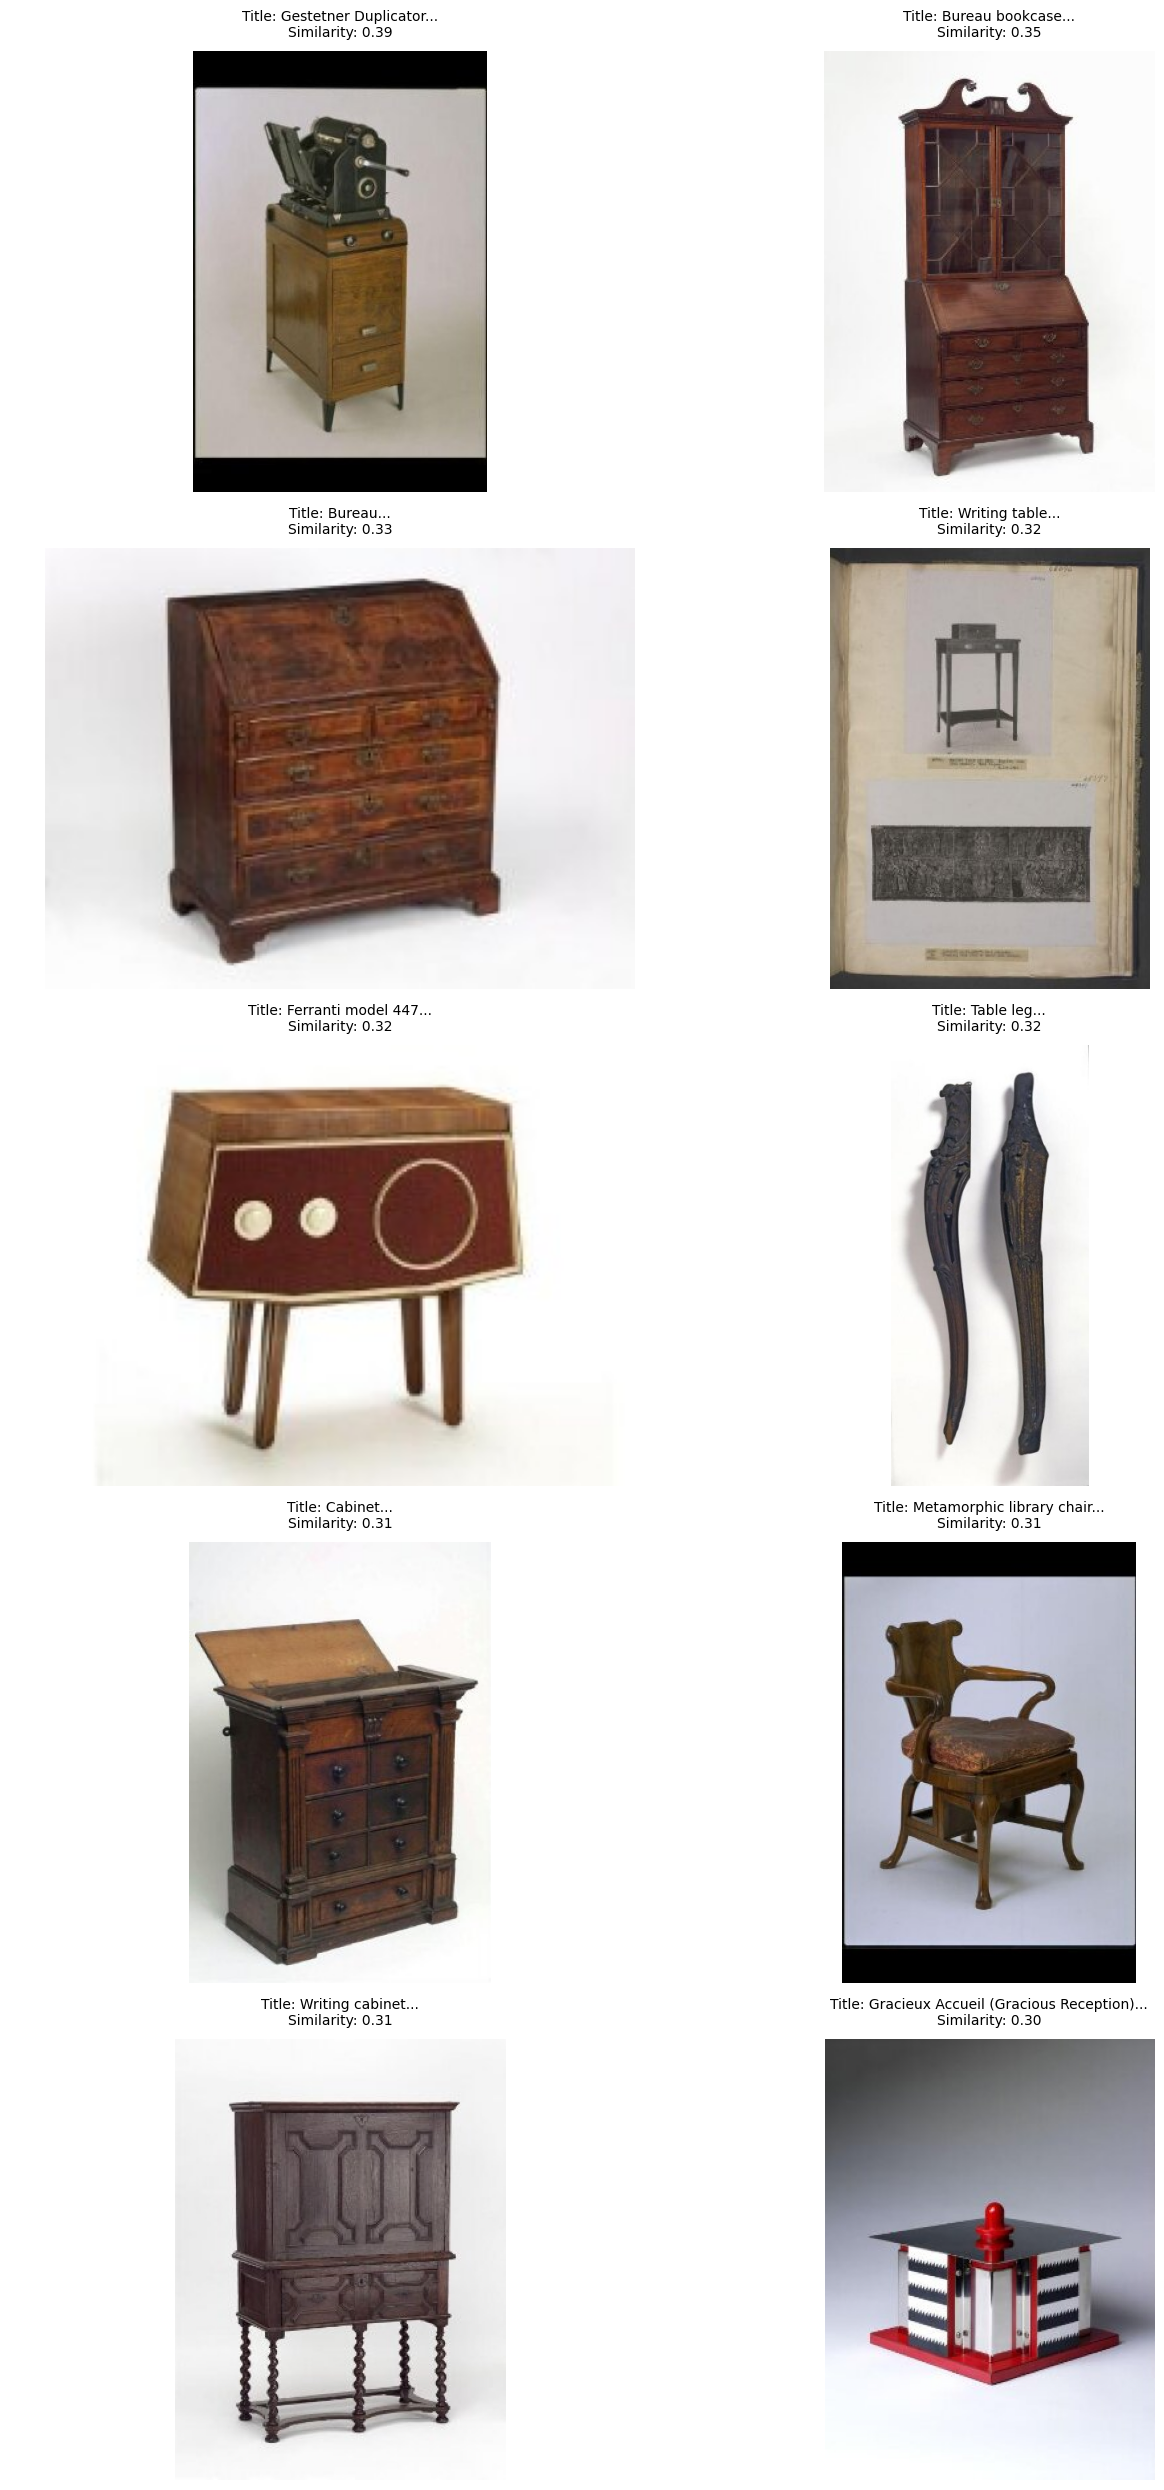


Detailed information：

1. Title: Gestetner Duplicator
   Similarity: 0.3898
   ID: 3819
   Describe: This machine is an example of an early photocopier. In 1929 Gestetner, the leading manufacturer of duplicators approached the American designer Raymond Loewy. They asked him to improve the appearance ...

2. Title: Bureau bookcase
   Similarity: 0.3500
   ID: 1821
   Describe: A bureau bookcase consists of a bureau surmounted by a bookcase with glazed or panelled doors. The hinged flap folds down, resting on wooden supports, or lopers, to form a writing surface. This exampl...

3. Title: Bureau
   Similarity: 0.3263
   ID: 1401
   Describe: A bureau, designed for writing, has a hinged writing surface which rests at 45 degrees when closed. This was both a space-saving device and a means of locking away papers and other private contents. W...

4. Title: Writing table
   Similarity: 0.3243
   ID: 662
   Describe: The variety of small tables and desks made in the later 18th century is asto

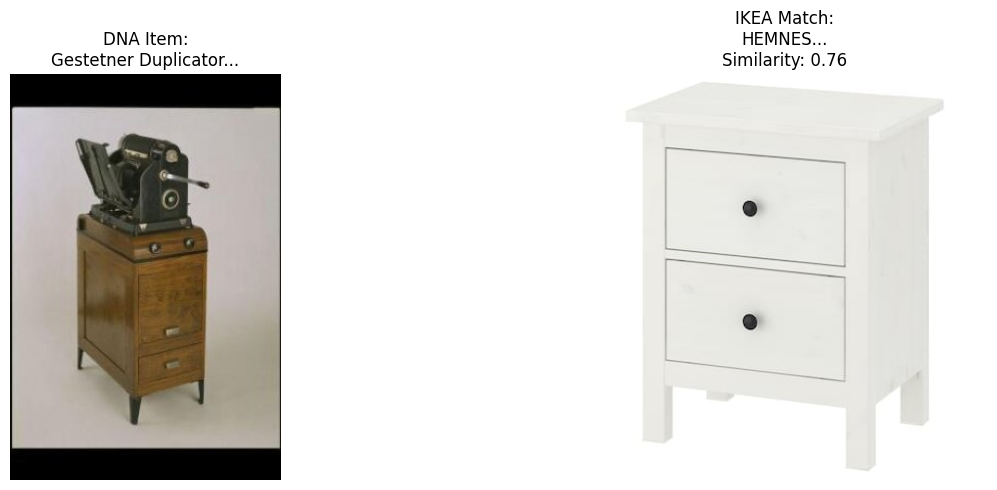


DNA Item: Bureau bookcase
Matched IKEA Item: HAUGA
Category: wardrobe
Similarity Score: 0.7934
ID: 1303
--------------------------------------------------------------------------------


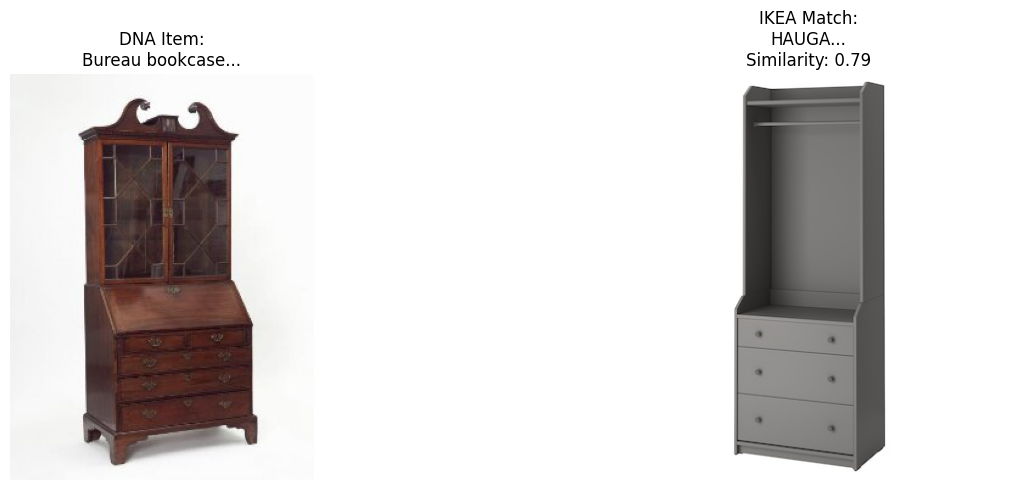


DNA Item: Bureau
Matched IKEA Item: BJÖRKSNÄS
Category: table
Similarity Score: 0.8811
ID: 1119
--------------------------------------------------------------------------------


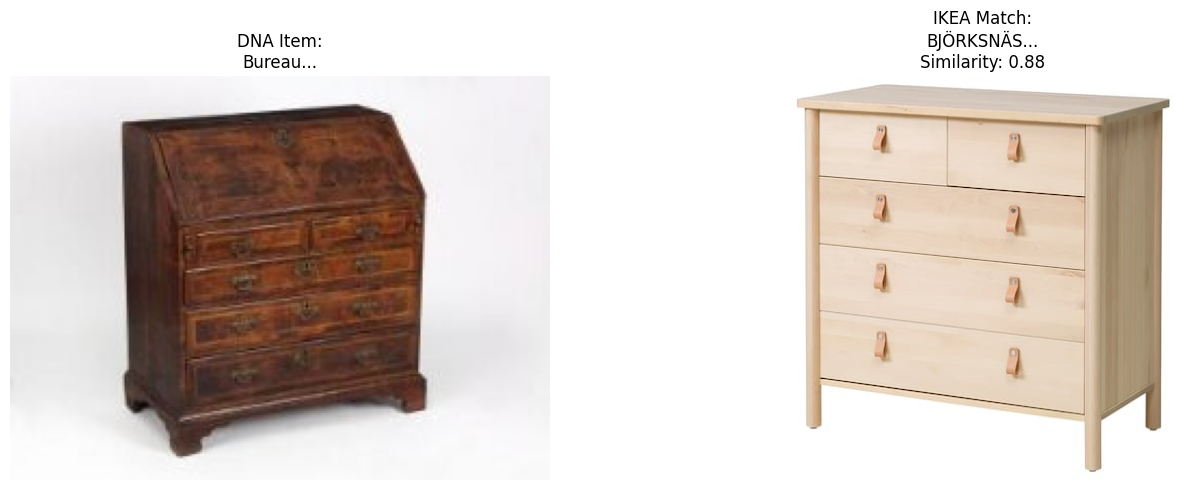


DNA Item: Writing table
Matched IKEA Item: EKET
Category: shelf
Similarity Score: 0.6706
ID: 1007
--------------------------------------------------------------------------------


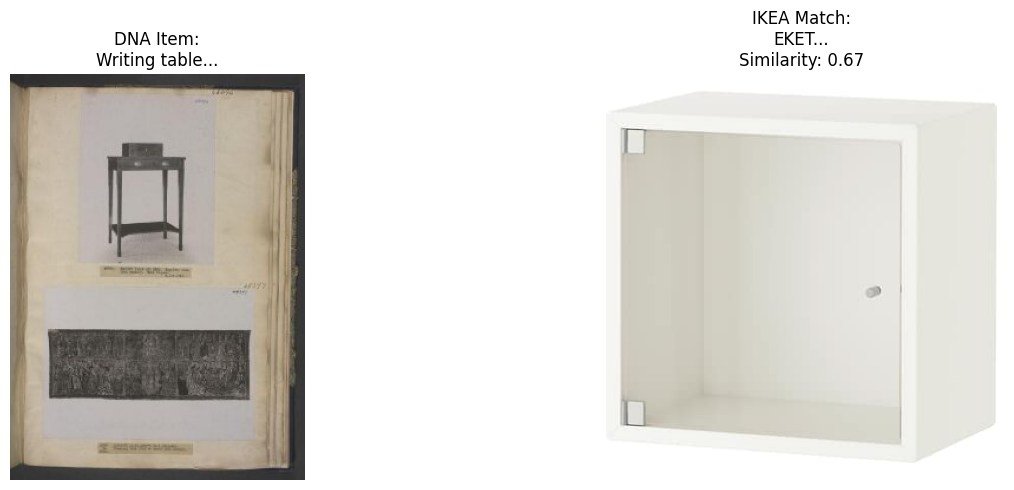


DNA Item: Ferranti model 447
Matched IKEA Item: KÄTTIL
Category: chair
Similarity Score: 0.8288
ID: 288
--------------------------------------------------------------------------------



DNA Item: Table leg
Matched IKEA Item: ÄLVSTA
Category: chair
Similarity Score: 0.6703
ID: 328
--------------------------------------------------------------------------------


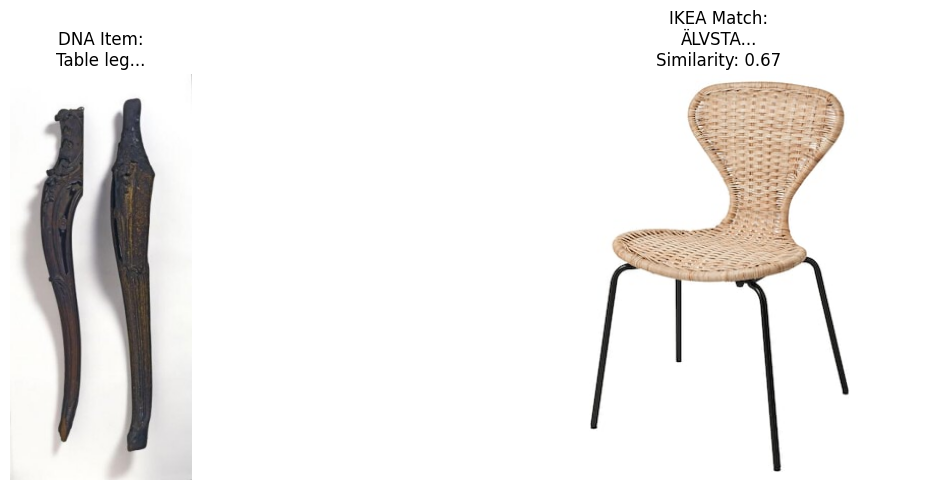


DNA Item: Cabinet
Matched IKEA Item: BJÖRKSNÄS
Category: table
Similarity Score: 0.8602
ID: 1119
--------------------------------------------------------------------------------


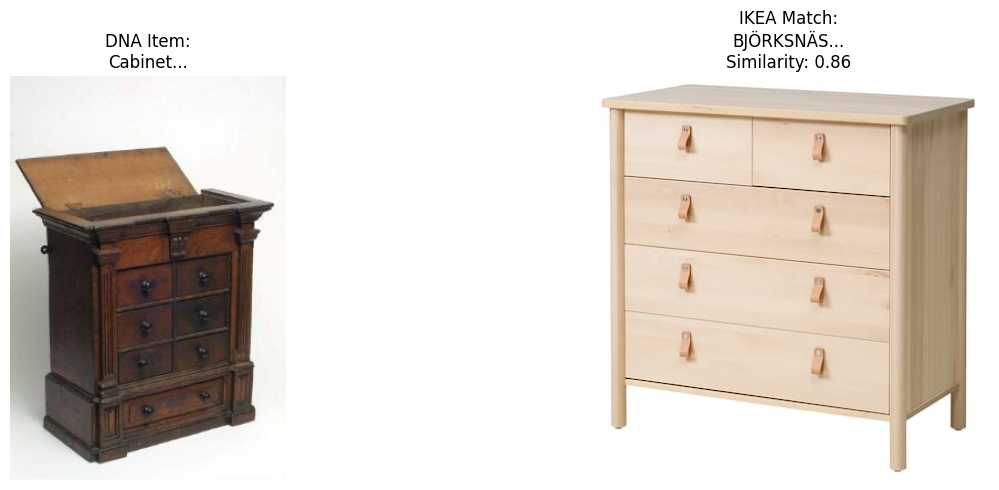


DNA Item: Metamorphic library chair
Matched IKEA Item: POÄNG
Category: chair
Similarity Score: 0.8102
ID: 477
--------------------------------------------------------------------------------


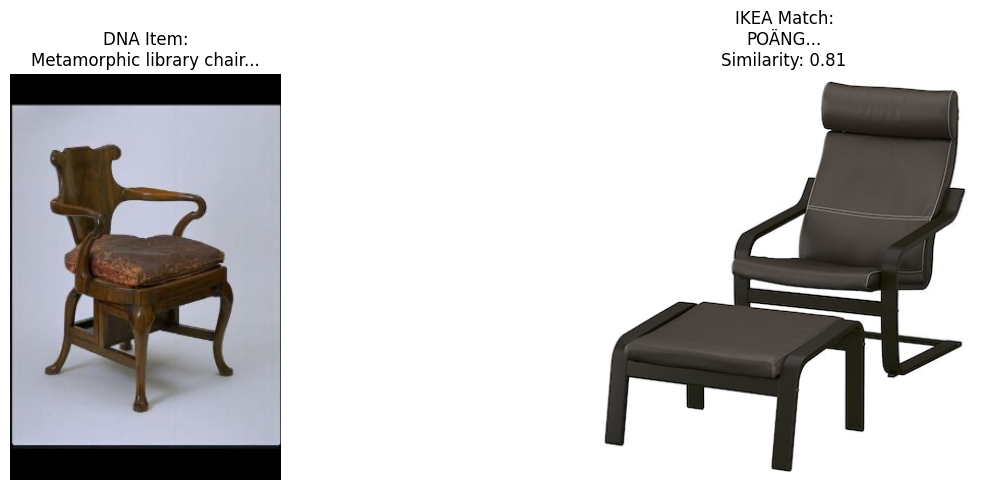


DNA Item: Writing cabinet
Matched IKEA Item: TORNVIKEN
Category: shelf
Similarity Score: 0.7777
ID: 968
--------------------------------------------------------------------------------


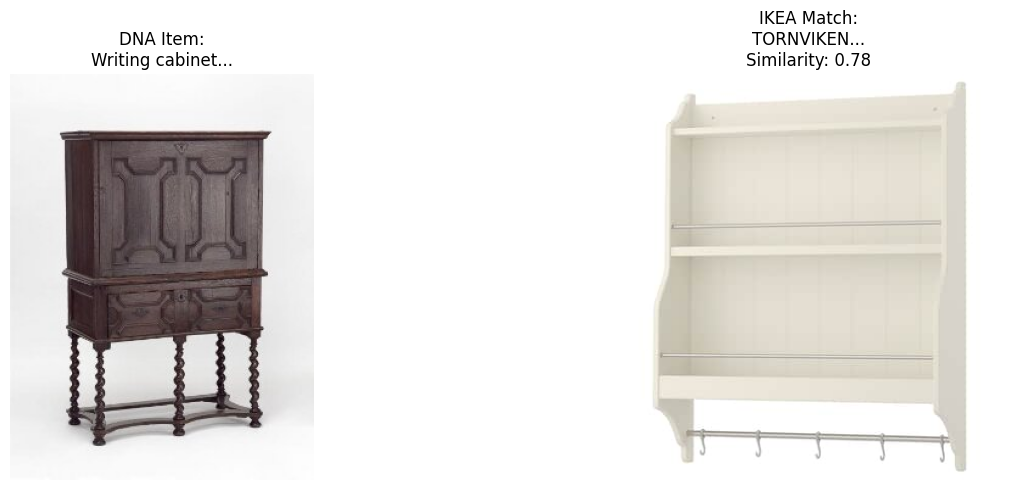


DNA Item: Gracieux Accueil (Gracious Reception)
Matched IKEA Item: BRIMNES
Category: bed
Similarity Score: 0.6628
ID: 51
--------------------------------------------------------------------------------


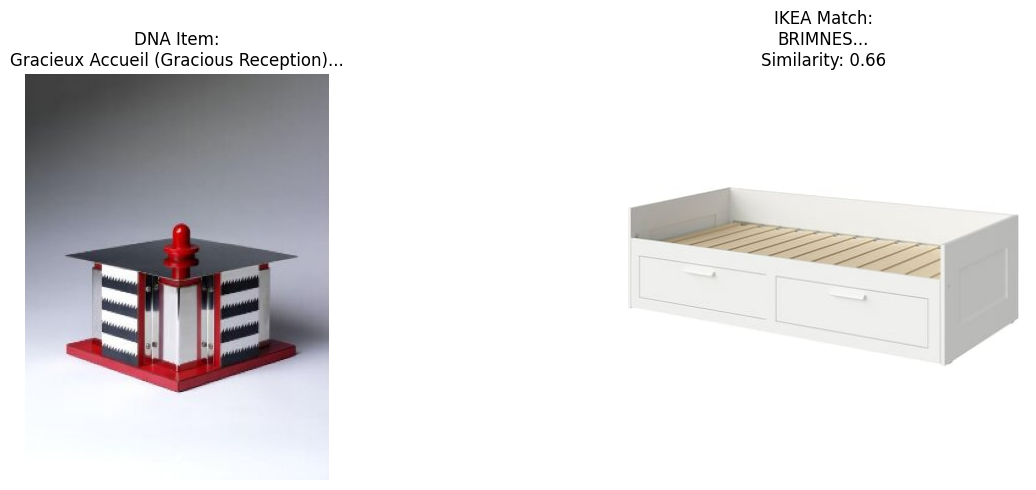

In [19]:
dna_results_df, _ = search_similar_artifacts_fast(input_text, top_k=10)

display_matching_results(dna_results_df, ikea_df)